this notebook looks at the survey area and the number of visits for three cases:
- non-DD
- ebv<0.2
- extragalactic footprint (ebv<0.2, depth cut, coverage in all six bands)

we look at these numbers for a few simualations including baseline v1.5, combo-dust (v1.6), baseline v1.7, and footprint8 (v1.7). in particular, we also look at minion1016 since that is the sim used in DESC SRD; note that the depth cut minion is i=26.0, while its i=25.9 for the rest.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
%matplotlib inline

In [2]:
import copy
import time

In [3]:
import time
import copy
import numpy as np
import healpy as hp
import os
import lsst.sims.maf.db as db
import lsst.sims.maf.metrics as metrics
import lsst.sims.maf.slicers as slicers
import lsst.sims.maf.metricBundles as metricBundles

import lsst.sims.maf.maps as maps

In [4]:
# import plot settings
import sys
sys.path.append('/global/homes/a/awan/my-utils/')
from pyutils import settings

In [5]:
base_path = '/global/cscratch1/sd/awan'
dbs_dict = {}

dbs_dict['minion1016'] = '%s/dbs_old_unzipped/minion_1016_sqlite.db' % base_path

dbs_dict['baseline v1.5 (1x30)'] = '%s/dbs_post_wp_v1.5/baseline_v1.5_10yrs.db' % base_path
dbs_dict['combo dust (v1.6; 1x30)'] = '%s/dbs_post_wp_v1.6/combo_dust_v1.6_10yrs.db' % base_path
dbs_dict['combo dust (v1.6; 2x15)'] = '%s/dbs_post_wp_v1.6/combo_dust_nexp2_v1.6_10yrs.db' % base_path
dbs_dict['baseline v1.7 (2x15)'] = '%s/dbs_post_wp_v1.7/baseline_nexp2_v1.7_10yrs.db' % base_path

dbs_dict['footprint 6 (v1.7; 2x15)'] = '%s/dbs_post_wp_v1.7/footprint_6_v1.710yrs.db' % base_path
dbs_dict['footprint 8 (v1.7; 2x15)'] = '%s/dbs_post_wp_v1.7/footprint_8_v1.710yrs.db' % base_path

### first confirm the numExposures

(and save the units on the ra/dec values)

In [6]:
latLonDegs = {}

for dbname in dbs_dict:
    opsdb = db.OpsimDatabase(dbs_dict[dbname])
    if 'Summary' not in opsdb.columnNames: # i.e. we are looking at non-minion1016
        simdata = opsdb.fetchMetricData(['numExposures'], sqlconstraint=None)
        print('%s: numExposures: %s' % (dbname, np.unique(simdata)[0][0]) )
        
    latLonDegs[dbname] = opsdb.raDecInDeg

baseline v1.5 (1x30): numExposures: 1
combo dust (v1.6; 1x30): numExposures: 1
combo dust (v1.6; 2x15): numExposures: 2
baseline v1.7 (2x15): numExposures: 2
footprint 6 (v1.7; 2x15): numExposures: 2
footprint 8 (v1.7; 2x15): numExposures: 2


#### get all nvisits

In [7]:
outdir = 'test/'
resultsDb = db.ResultsDb(outDir=outdir)

def get_all_visits(sqlconstraint_dict):

    all_visits_bundle = {}
    for dbname in dbs_dict:
        print('## %s' % dbname)
        sqlconstraint =  print('## sqlconstraint: %s' % sqlconstraint_dict[dbname])
            
        opsdb = db.OpsimDatabase(dbs_dict[dbname]) #opsdbs[dbname]

        # set up the metric
        if dbname == 'minion1016':
            colname = 'expMJD'
        else:
            colname = 'observationStartMJD'
        metric = metrics.CountUniqueMetric(colname, metricName='Nvisits')

        # set up slicer
        slicer = slicers.UniSlicer()

        # setup the bundle
        all_visits_bundle[dbname] = metricBundles.MetricBundle(metric, slicer, sqlconstraint)
        # set up the group.
        grp = metricBundles.MetricBundleGroup({0: all_visits_bundle[dbname]}, opsdb, outDir=outdir,
                                              resultsDb=resultsDb, saveEarly=False)
        grp.runAll()

        # plot the map
        print('total visits: %s\n\n' % np.sum(all_visits_bundle[dbname].metricValues))
        
    return all_visits_bundle

In [8]:
# consider DD visits
sqlconstraint_dict_dd = {}
for dbname in dbs_dict:
    if dbname == 'minion1016':
        opsdb = db.OpsimDatabase(dbs_dict[dbname]) #opsdbs[dbname]
        prop_ids, prop_tags = opsdb.fetchPropInfo()
        sqlconstraint_dict_dd[dbname] = opsdb.createSQLWhere('DD', prop_tags)
    else:
        sqlconstraint_dict_dd[dbname] = 'note like "DD%"'
    
all_visits_dd = get_all_visits(sqlconstraint_dict_dd)

## minion1016
## sqlconstraint: propID = 56
Querying database Summary with no constraint for columns ['expMJD'].
Found 2447931 visits
Running:  [0]
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
total visits: 2447931.0


## baseline v1.5 (1x30)
## sqlconstraint: note like "DD%"
Querying database SummaryAllProps with no constraint for columns ['observationStartMJD'].
Found 2224095 visits
Running:  [0]
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
total visits: 2224095.0


## combo dust (v1.6; 1x30)
## sqlconstraint: note like "DD%"
Querying database SummaryAllProps with no constraint for columns ['observationStartMJD'].
Found 2237663 visits
Running:  [0]
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
total visits: 2237663.0


## combo dust (v1.6; 2x15)
## sqlconstraint: note like "DD%"
Querying database SummaryAllProps with no constraint for columns ['o

In [9]:
sqlconstraint_dict_nondd = {}
for dbname in dbs_dict:
    if dbname == 'minion1016':
        sqlconstraint_dict_nondd[dbname] = 'propID != 56'
    else:
        sqlconstraint_dict_nondd[dbname] = 'note not like "DD%"'
# consider non-DD visits
all_visits_nondd = get_all_visits(sqlconstraint_dict_nondd)

## minion1016
## sqlconstraint: propID != 56
Querying database Summary with no constraint for columns ['expMJD'].
Found 2447931 visits
Running:  [0]
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
total visits: 2447931.0


## baseline v1.5 (1x30)
## sqlconstraint: note not like "DD%"
Querying database SummaryAllProps with no constraint for columns ['observationStartMJD'].
Found 2224095 visits
Running:  [0]
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
total visits: 2224095.0


## combo dust (v1.6; 1x30)
## sqlconstraint: note not like "DD%"
Querying database SummaryAllProps with no constraint for columns ['observationStartMJD'].
Found 2237663 visits
Running:  [0]
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
total visits: 2237663.0


## combo dust (v1.6; 2x15)
## sqlconstraint: note not like "DD%"
Querying database SummaryAllProps with no constraint fo

#### get the healpix map for nvisits

In [10]:
nside = 64
area_ppixel = hp.nside2pixarea(nside=nside, degrees=True)

# set up slicer
slicers_dict = {}
for dbname in dbs_dict:
    slicers_dict[dbname] = slicers.HealpixSlicer(lonCol='fieldRA', latCol='fieldDec',
                                            latLonDeg=latLonDegs[dbname], nside=nside, useCache=False)

Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes


In [11]:
# get the footprint
nvisits_alls = {}
for dbname in dbs_dict:
    time0 = time.time()
    opsdb = db.OpsimDatabase(dbs_dict[dbname]) #opsdbs[dbname]

    # set up the metric
    if dbname == 'minion1016':
            colname = 'expMJD'
    else:
        colname = 'observationStartMJD'
    metric = metrics.CountUniqueMetric(colname, metricName='Nvisits')

    # setup the bundle
    nvisits_alls[dbname] = metricBundles.MetricBundle(metric, slicers_dict[dbname], sqlconstraint_dict_nondd[dbname])
    # set up the group.
    grp = metricBundles.MetricBundleGroup({0: nvisits_alls[dbname]}, opsdb, outDir=outdir,
                                          resultsDb=resultsDb, saveEarly=False)
    grp.runAll()
    print('## time taken: %.2f min\n' % ((time.time() - time0) / 60))

Querying database Summary with constraint propID != 56 for columns ['expMJD', 'fieldRA', 'fieldDec']
Found 2336810 visits
Running:  [0]
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
## time taken: 0.98 min

Querying database SummaryAllProps with constraint note not like "DD%" for columns ['observationStartMJD', 'fieldRA', 'fieldDec']
Found 2122606 visits
Running:  [0]
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
## time taken: 0.42 min

Querying database SummaryAllProps with constraint note not like "DD%" for columns ['observationStartMJD', 'fieldRA', 'fieldDec']
Found 2135532 visits
Running:  [0]
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
## time taken: 0.42 min

Querying database SummaryAllProps with constraint note not like "DD%" for columns ['observationStartMJD', 'fieldRA', 'fieldDec']
Found 1975275 visits
Running:  [0]
Completed metric gene

/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-0.5.0/lib/python3.8/site-packages/healpy/projaxes.py:920: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("viridis").copy()
  newcm.set_over(newcm(1.0))
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-0.5.0/lib/python3.8/site-packages/healpy/projaxes.py:921: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("viridis").copy()
  newcm.set_under(bgcolor)
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-s

<Figure size 720x432 with 0 Axes>

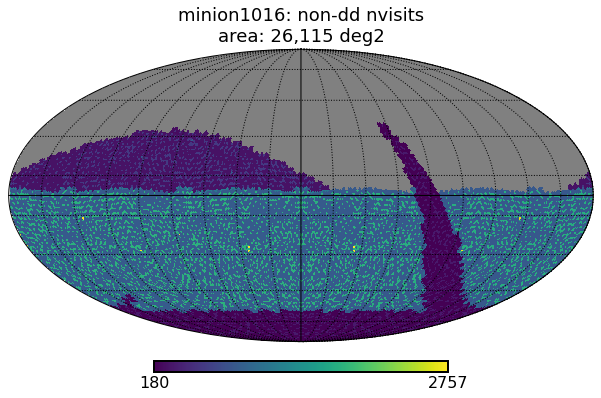

<Figure size 720x432 with 0 Axes>

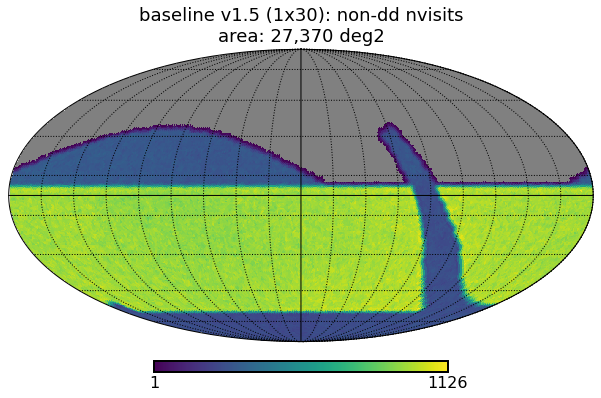

<Figure size 720x432 with 0 Axes>

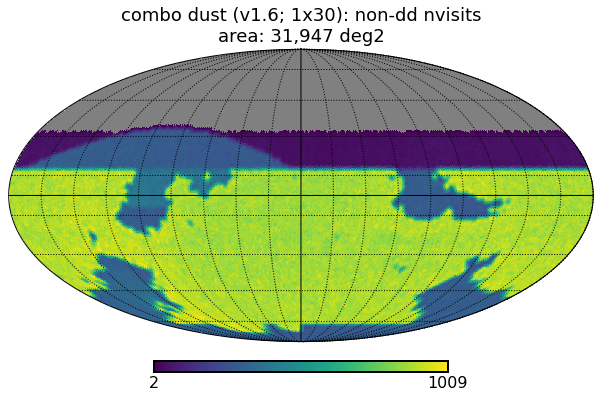

<Figure size 720x432 with 0 Axes>

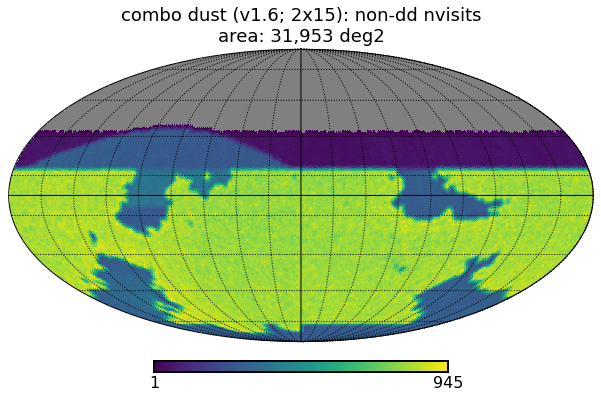

<Figure size 720x432 with 0 Axes>

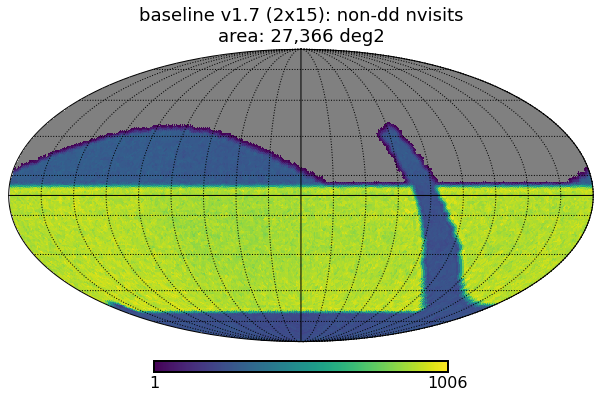

<Figure size 720x432 with 0 Axes>

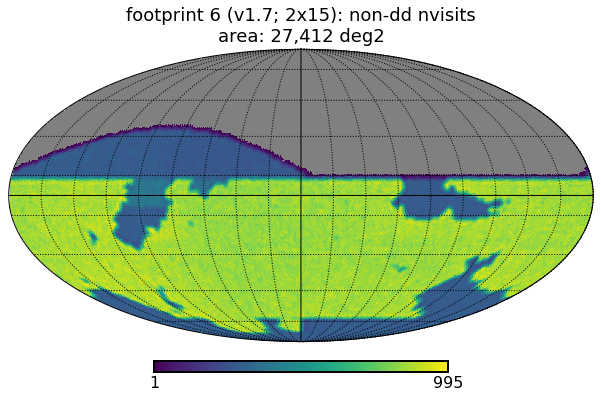

<Figure size 720x432 with 0 Axes>

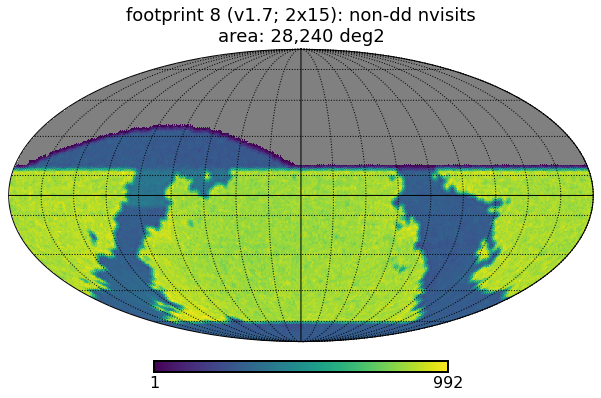

In [12]:
# plot things
for dbname in nvisits_alls:
    plt.clf()
    area = (len(np.where(nvisits_alls[dbname].metricValues.mask == False)[0]) * area_ppixel)
    
    title = f'{dbname}: non-dd nvisits\narea: {int(area):,} deg2'
    
    hp.mollview( nvisits_alls[dbname].metricValues, flip='astro', rot=(0,0,0), title=title)
    hp.graticule(dpar=20, dmer=20, verbose=False)
    plt.show()

#### get all nvisits in eg-footprint

In [13]:
# set up the dust map
dustmap = maps.DustMap(nside=nside, interp=False)

nfilters_needed = 6
lim_ebv = 0.2

In [14]:
import sys
sys.path.append('/global/homes/a/awan/LSST/lsstRepos/sims_maf_contrib/mafContrib/lssmetrics')
from egFootprintMetric import egFootprintMetric

In [15]:
sqlconstraint = ' note not like "DD%"'

# get the footprint
eg_mask = {}
for dbname in dbs_dict:
    time0 = time.time()
    opsdb = db.OpsimDatabase(dbs_dict[dbname]) #opsdbs[dbname]

    # set up the metric
    #metric = metrics.ExgalM5_with_cuts(lsstFilter='i', nFilters=nfilters_needed,
    #                                   extinction_cut=lim_ebv, depth_cut=ptsrc_lim_mag_i)
    if dbname == 'minion1016':
        ptsrc_lim_mag_i = 26.0
    else:
        ptsrc_lim_mag_i = 25.9
    metric = egFootprintMetric(nfilters_needed=nfilters_needed, lim_mag_i_ptsrc=ptsrc_lim_mag_i,
                               lim_ebv=lim_ebv, return_coadd_band='i')


    # setup the bundle
    bundle = metricBundles.MetricBundle(metric, slicers_dict[dbname], sqlconstraint_dict_nondd[dbname], mapsList=[dustmap])
    # set up the group.
    grp = metricBundles.MetricBundleGroup({0: bundle}, opsdb, outDir=outdir,
                                          resultsDb=resultsDb, saveEarly=False)
    grp.runAll()
    
    eg_mask[dbname] = bundle.metricValues.mask
    print('## time taken: %.2f min\n' % ((time.time() - time0) / 60))

Querying database Summary with constraint propID != 56 for columns ['filter', 'fieldRA', 'fieldDec', 'fiveSigmaDepth']
Found 2336810 visits
Running:  [0]
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
## time taken: 1.00 min

Querying database SummaryAllProps with constraint note not like "DD%" for columns ['filter', 'fieldRA', 'fieldDec', 'fiveSigmaDepth']
Found 2122606 visits
Running:  [0]
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
## time taken: 0.94 min

Querying database SummaryAllProps with constraint note not like "DD%" for columns ['filter', 'fieldRA', 'fieldDec', 'fiveSigmaDepth']
Found 2135532 visits
Running:  [0]
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
## time taken: 0.95 min

Querying database SummaryAllProps with constraint note not like "DD%" for columns ['filter', 'fieldRA', 'fieldDec', 'fiveSigmaDepth']
Found 1975275 visits
Ru

<Figure size 720x432 with 0 Axes>

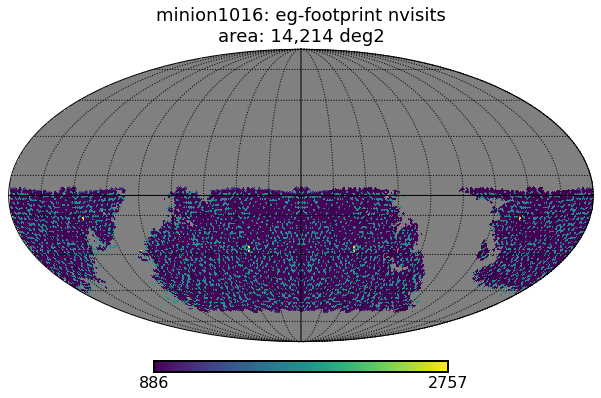

<Figure size 720x432 with 0 Axes>

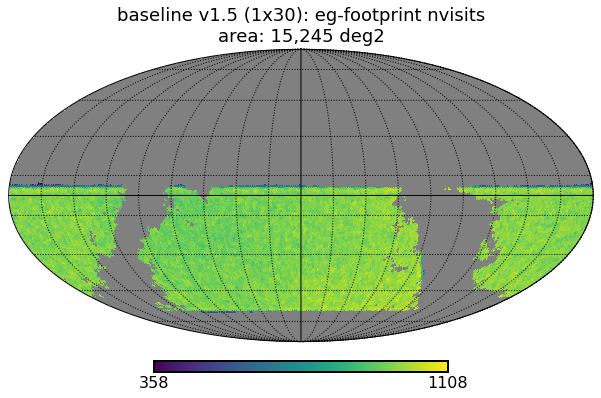

<Figure size 720x432 with 0 Axes>

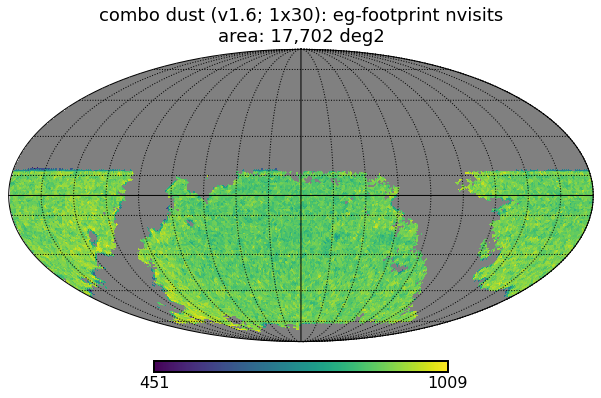

<Figure size 720x432 with 0 Axes>

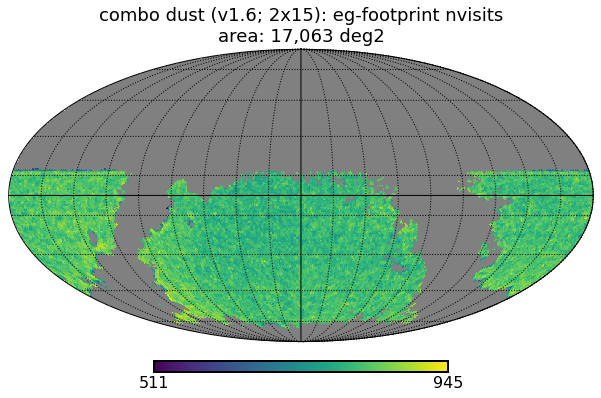

<Figure size 720x432 with 0 Axes>

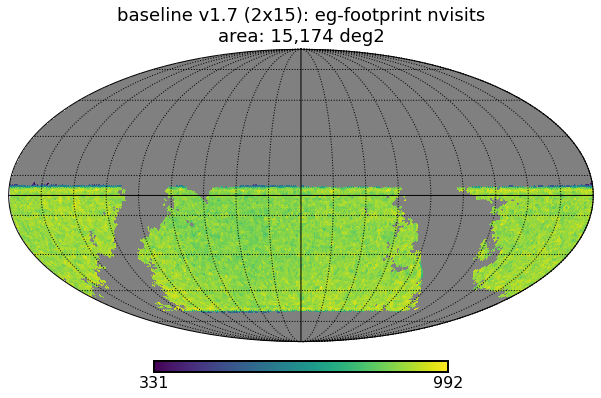

<Figure size 720x432 with 0 Axes>

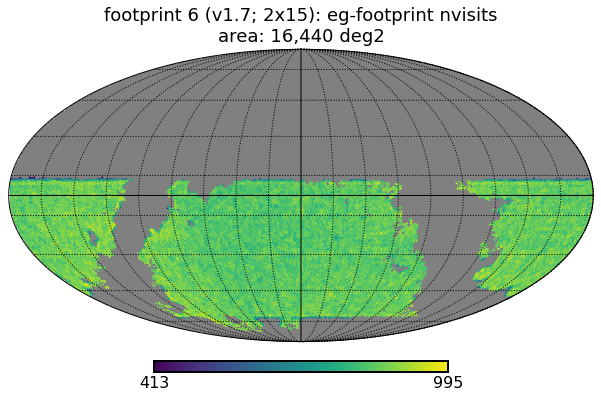

<Figure size 720x432 with 0 Axes>

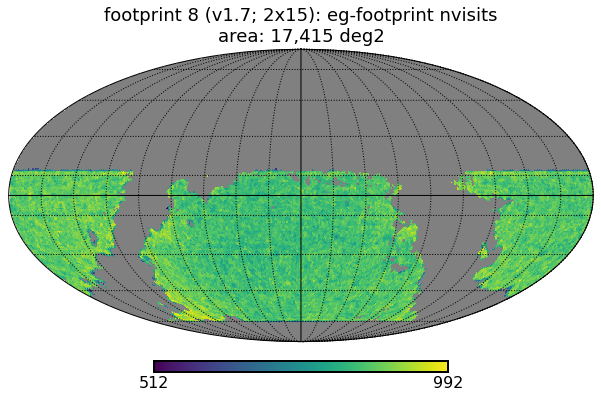

In [16]:
# plot things
nvisits_eg = copy.deepcopy(nvisits_alls)
for dbname in nvisits_alls:
    nvisits_eg[dbname].metricValues.mask = eg_mask[dbname]
    
    plt.clf()
    area = (len(np.where(nvisits_eg[dbname].metricValues.mask == False)[0]) * area_ppixel)
    title = f'{dbname}: eg-footprint nvisits\narea: {int(area):,} deg2'

    hp.mollview( nvisits_eg[dbname].metricValues, flip='astro', rot=(0,0,0), title=title)
    hp.graticule(dpar=20, dmer=20, verbose=False)
    plt.show()

#### get all nvisits in ebv<0.2 region

In [17]:
sqlconstraint = ' note not like "DD%"'

# get the footprint
ebvlim_mask = {}
for dbname in dbs_dict:
    time0 = time.time()
    opsdb = db.OpsimDatabase(dbs_dict[dbname])

    # set up the metric
    #metric = metrics.ExgalM5_with_cuts(lsstFilter='i', nFilters=1,
    #                                   extinction_cut=lim_ebv, depth_cut=20)
    metric = egFootprintMetric(nfilters_needed=1, lim_mag_i_ptsrc=20,
                               lim_ebv=lim_ebv, return_coadd_band=None)
    
    # setup the bundle
    bundle = metricBundles.MetricBundle(metric, slicers_dict[dbname], sqlconstraint_dict_nondd[dbname], mapsList=[dustmap])
    # set up the group.
    grp = metricBundles.MetricBundleGroup({0: bundle}, opsdb, outDir=outdir,
                                          resultsDb=resultsDb, saveEarly=False)
    grp.runAll()
    
    ebvlim_mask[dbname] = bundle.metricValues.mask
    print('time taken: %.2f min\n' % ((time.time() - time0) / 60))

Querying database Summary with constraint propID != 56 for columns ['filter', 'fieldRA', 'fieldDec', 'fiveSigmaDepth']
Found 2336810 visits
Running:  [0]
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
time taken: 1.02 min

Querying database SummaryAllProps with constraint note not like "DD%" for columns ['filter', 'fieldRA', 'fieldDec', 'fiveSigmaDepth']
Found 2122606 visits
Running:  [0]
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
time taken: 0.94 min

Querying database SummaryAllProps with constraint note not like "DD%" for columns ['filter', 'fieldRA', 'fieldDec', 'fiveSigmaDepth']
Found 2135532 visits
Running:  [0]
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
time taken: 0.96 min

Querying database SummaryAllProps with constraint note not like "DD%" for columns ['filter', 'fieldRA', 'fieldDec', 'fiveSigmaDepth']
Found 1975275 visits
Running:  [

<Figure size 720x432 with 0 Axes>

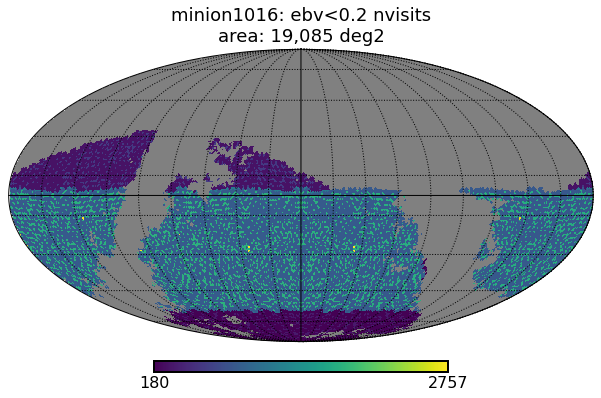

<Figure size 720x432 with 0 Axes>

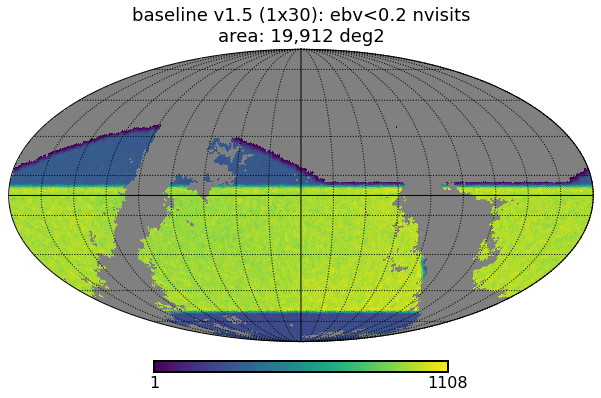

<Figure size 720x432 with 0 Axes>

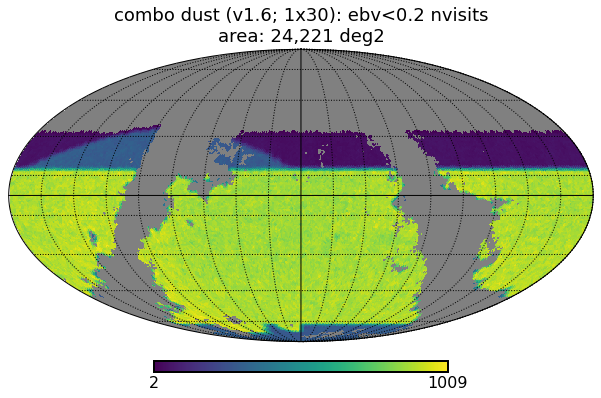

<Figure size 720x432 with 0 Axes>

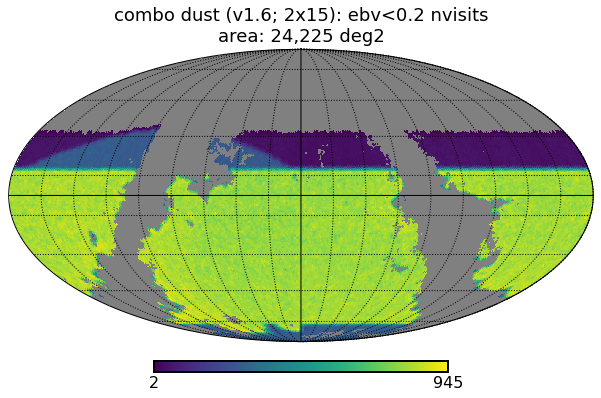

<Figure size 720x432 with 0 Axes>

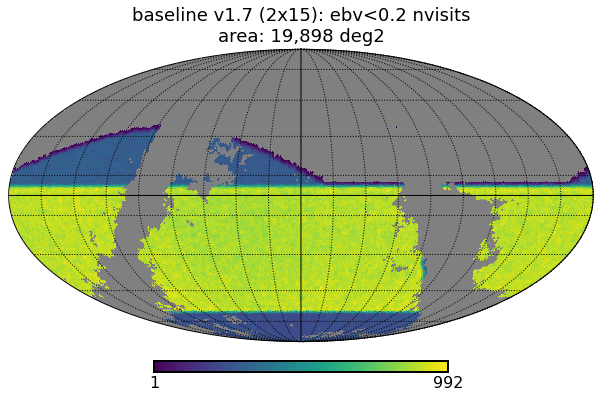

<Figure size 720x432 with 0 Axes>

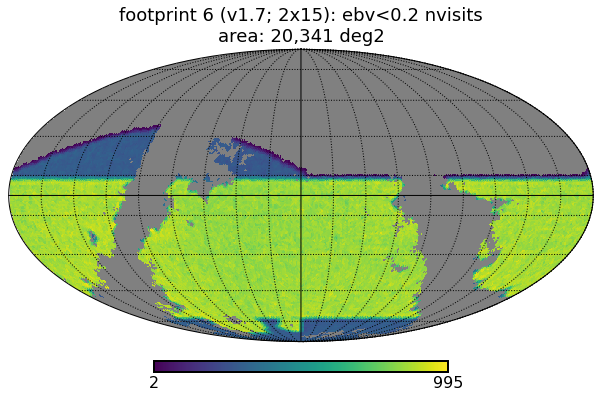

<Figure size 720x432 with 0 Axes>

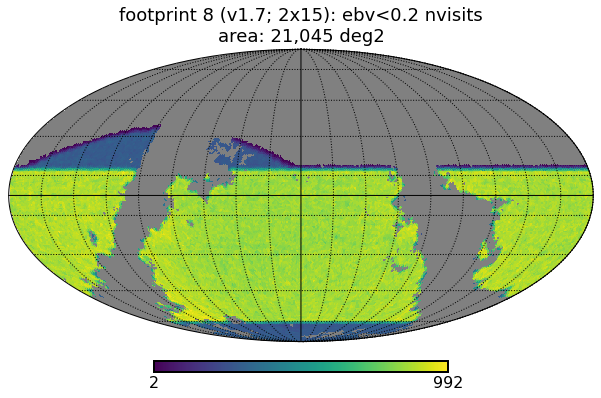

In [18]:
# plot things
nvisits_ebvlim = copy.deepcopy(nvisits_alls)
for dbname in nvisits_alls:
    nvisits_ebvlim[dbname].metricValues.mask = ebvlim_mask[dbname]
    
    plt.clf()

    area = (len(np.where(nvisits_ebvlim[dbname].metricValues.mask == False)[0]) * area_ppixel)
    title = f'{dbname}: ebv<0.2 nvisits\narea: {int(area):,} deg2'
    
    hp.mollview( nvisits_ebvlim[dbname].metricValues, flip='astro', rot=(0,0,0), title=title)
    hp.graticule(dpar=20, dmer=20, verbose=False)
    plt.show()

### summary

since there's no simple way to get the total visits in a selected footprint, we will use the total numbers in non-dd alongside fractions of total repeated visits in the healpix maps

In [19]:
 for dbname in nvisits_alls:
    print('## %s' % dbname)
    
    constraint_name = 'non-dd'
    
    nvis_all = np.sum(all_visits_nondd[dbname].metricValues)
    #print('total %s visits: : %s' % (constraint_name, nvis_all))
    print(f'total {constraint_name} visits: {nvis_all:n}')
    
    # healpix: all non-dd visits
    unmasked = np.where(nvisits_alls[dbname].metricValues.mask == False)[0]
    nvis_all_hp = np.sum(nvisits_alls[dbname].metricValues.data[unmasked])
    print(f'-- total {constraint_name} healpix-visits: {nvis_all_hp:n}') # \
    #            ({100 * nvis_all / nvis_all_hp :.2f} % of nvis_all)')
    
    # healpix: ebv<0.2 visits
    unmasked = np.where(ebvlim_mask[dbname] == False)[0]
    nvis_ebvlim_hp = np.sum(nvisits_alls[dbname].metricValues.data[unmasked])
    percent = nvis_ebvlim_hp / nvis_all_hp
    nvis_ebvlim = percent * nvis_all
    #print(f'-- total ebv<0.2 healpix-visits: %s (%.2f %% of nvis_all_hp => %.f total visits)' % (nvis_ebvlim_hp, 100 * percent, nvis_ebvlim) )
    print(f'-- total ebv<0.2 healpix-visits: {nvis_ebvlim_hp:n} \
                ({100 * percent:.2f}% of nvis_all_hp => {nvis_ebvlim:n} total visits)')
    
    # healpix: eg visits
    unmasked = np.where(eg_mask[dbname] == False)[0]
    nvis_eg_hp = np.sum(nvisits_alls[dbname].metricValues.data[unmasked])
    percent = nvis_eg_hp / nvis_all_hp
    nvis_eg = percent * nvis_all
    #print('-- total eg healpix-visits : %s (%.2f %% of nvis_all_hp => %.f total visits (%.2f%% of ebv<0.2 total visits))' % (nvis_eg_hp, 100 * percent, nvis_eg, 100 * nvis_eg / nvis_ebvlim) )
    print(f'-- total eg healpix-visits: {nvis_eg_hp:n} \
                ({100 * percent:.2f}% of nvis_all_hp => {nvis_eg:n} total visits ({100 * nvis_eg / nvis_ebvlim:.2f}% of ebv<0.2 total visits))')
    
    print('')

## minion1016
total non-dd visits: 2.44793e+06
-- total non-dd healpix-visits: 2.67752e+07
-- total ebv<0.2 healpix-visits: 2.11537e+07                (79.00% of nvis_all_hp => 1.93398e+06 total visits)
-- total eg healpix-visits: 1.90344e+07                (71.09% of nvis_all_hp => 1.74022e+06 total visits (89.98% of ebv<0.2 total visits))

## baseline v1.5 (1x30)
total non-dd visits: 2.2241e+06
-- total non-dd healpix-visits: 2.43086e+07
-- total ebv<0.2 healpix-visits: 1.90314e+07                (78.29% of nvis_all_hp => 1.74126e+06 total visits)
-- total eg healpix-visits: 1.74288e+07                (71.70% of nvis_all_hp => 1.59464e+06 total visits (91.58% of ebv<0.2 total visits))

## combo dust (v1.6; 1x30)
total non-dd visits: 2.23766e+06
-- total non-dd healpix-visits: 2.44551e+07
-- total ebv<0.2 healpix-visits: 2.03734e+07                (83.31% of nvis_all_hp => 1.86418e+06 total visits)
-- total eg healpix-visits: 1.85734e+07                (75.95% of nvis_all_hp => 1.6994

a simpler way to do things is to calculate the ratio between total visits and total healpix-visits, and just use that. also lets include area in the print statements.

In [20]:
 for dbname in nvisits_alls:
    print('## %s' % dbname)
    
    constraint_name = 'non-dd'
    
    nvis_all = np.sum(all_visits_nondd[dbname].metricValues)
    
    area = (len(np.where(nvisits_alls[dbname].metricValues.mask == False)[0]) * area_ppixel)
    print(f'total {constraint_name} visits: {nvis_all:n} (area: {int(area):,} deg2)')
    
    # healpix: all non-dd visits
    unmasked = np.where(nvisits_alls[dbname].metricValues.mask == False)[0]
    nvis_all_hp = np.sum(nvisits_alls[dbname].metricValues.data[unmasked])
    #print(f'-- total {constraint_name} healpix-visits: {nvis_all_hp:n}')
    
    ratio_tot_hptot = nvis_all / nvis_all_hp
    
    # healpix: ebv<0.2 visits
    unmasked = np.where(ebvlim_mask[dbname] == False)[0]
    nvis_ebvlim_hp = np.sum(nvisits_alls[dbname].metricValues.data[unmasked])
    nvis_ebvlim = ratio_tot_hptot * nvis_ebvlim_hp
    percent = nvis_ebvlim / nvis_all
    
    area = (len(np.where(ebvlim_mask[dbname] == False)[0]) * area_ppixel)
    
    print(f'-- total ebv<0.2 visits: {nvis_ebvlim:n} (area: {int(area):,} deg2) \
            (=> {100 * percent:.2f}% of total {constraint_name} visits)')
    
    # healpix: eg visits
    unmasked = np.where(eg_mask[dbname] == False)[0]
    nvis_eg_hp = np.sum(nvisits_alls[dbname].metricValues.data[unmasked])
    
    nvis_eg = ratio_tot_hptot * nvis_eg_hp
    percent = nvis_eg / nvis_all
    
    area = (len(np.where(eg_mask[dbname] == False)[0]) * area_ppixel)
    
    print(f'-- total eg visits: {nvis_eg:n} (area: {int(area):,} deg2) \
                (=> {100 * percent:.2f}% of total {constraint_name} visits ; {100 * nvis_eg / nvis_ebvlim:.2f}% of ebv<0.2 total visits)')
    
    print('')

## minion1016
total non-dd visits: 2.44793e+06 (area: 26,115 deg2)
-- total ebv<0.2 visits: 1.93398e+06 (area: 19,085 deg2)            (=> 79.00% of total non-dd visits)
-- total eg visits: 1.74022e+06 (area: 14,214 deg2)                (=> 71.09% of total non-dd visits ; 89.98% of ebv<0.2 total visits)

## baseline v1.5 (1x30)
total non-dd visits: 2.2241e+06 (area: 27,370 deg2)
-- total ebv<0.2 visits: 1.74126e+06 (area: 19,912 deg2)            (=> 78.29% of total non-dd visits)
-- total eg visits: 1.59464e+06 (area: 15,245 deg2)                (=> 71.70% of total non-dd visits ; 91.58% of ebv<0.2 total visits)

## combo dust (v1.6; 1x30)
total non-dd visits: 2.23766e+06 (area: 31,947 deg2)
-- total ebv<0.2 visits: 1.86418e+06 (area: 24,221 deg2)            (=> 83.31% of total non-dd visits)
-- total eg visits: 1.69949e+06 (area: 17,702 deg2)                (=> 75.95% of total non-dd visits ; 91.17% of ebv<0.2 total visits)

## combo dust (v1.6; 2x15)
total non-dd visits: 2.06977e+06 

In [21]:
tot1 = 2.44793e+06
tot2 = 2.04549e+06
100 * (tot1 - tot2) / tot1

16.44001258205913

In [22]:
tot1 = 1.74022e+06
tot2 = 1.45712e+06 
100 * (tot1 - tot2) / tot1

16.26805806162439